<a href="https://colab.research.google.com/github/jglaser/gigadocking_notebooks/blob/main/ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
#import os

import matplotlib.pyplot as plt
import seaborn as sns

# Normalizer
from sklearn.preprocessing import Normalizer

# ML classificator
from scipy import stats
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV, KFold
from sklearn.metrics import f1_score, confusion_matrix, precision_recall_fscore_support, precision_recall_curve 

import xgboost as xgb

#import openbabel 
#import pybel 

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


## Train BigQuery XGB

In [ ]:
project_id = 'cmb-covid19-discovery-collab'

In [ ]:
from google.colab import auth
auth.authenticate_user()
print('Authenticated')

Authenticated


In [ ]:
%%bigquery --project $project_id df
SELECT * FROM moonshot.mpro_features LIMIT 10

In [ ]:
import numpy as np
columns_moonshot = sorted([c for c in df.columns if c != 'string_field_0' and c.split('_')[-1] != 'tr'], key=lambda x: int(x.split('_')[1]))
columns_moonshot_tr = sorted([c for c in df.columns if c != 'string_field_0'], key=lambda x: int(x.split('_')[1]))


In [ ]:
q = "SELECT activities.f_avg_IC50,"+','.join(columns_moonshot) + \
f""" FROM moonshot.mpro_features
INNER JOIN moonshot.activities
ON activities.CID = mpro_features.string_field_0
"""
from google.cloud import bigquery
client = bigquery.Client(project=project_id)
df_features = client.query(q).to_dataframe()

In [ ]:
X = df_features[ columns_moonshot ]
y = df_features['f_avg_IC50'] < 5. 

param_dist = {'n_estimators': stats.randint(100, 500),
              'learning_rate': stats.uniform(0.01, 0.07),
              'subsample': stats.uniform(0.3, 0.7),
              'max_depth': [3, 4, 5, 6, 7, 8, 9],
              'colsample_bytree': stats.uniform(0.5, 0.45),
              'min_child_weight': [1, 2, 3]
             }

from sklearn.metrics import make_scorer

def my_scorer(clf, X, y_true):
    y_pred_proba = clf.predict_proba(X)[:,1]
    p, r, _ = precision_recall_curve(y_true, y_pred_proba)
    auc = np.trapz(p[::-1],r[::-1])
    return auc

clf_xgb = xgb.XGBClassifier(objective='binary:logistic', use_label_encoder=False)
# custom scoring function doesn't work with n_jobs = -1
clf = RandomizedSearchCV(clf_xgb, param_distributions = param_dist, n_iter = 100, scoring = my_scorer, error_score = 'raise', verbose=1)

numFolds = 5
folds = KFold(n_splits = numFolds, shuffle = True)

estimators = []
results = np.zeros(len(X))
scores = []
y_real = []
y_proba = []
for train_index, test_index in folds.split(X):
    X_train, X_test = X.iloc[train_index,:], X.iloc[test_index,:]
    y_train, y_test = y.iloc[train_index].values.ravel(), y.iloc[test_index].values.ravel()
    clf.fit(X_train, y_train)

    estimators.append(clf.best_estimator_)
    results[test_index] = clf.predict(X_test)
    pred_proba = clf.predict_proba(X_test)
    y_real.append(y_test)
    y_proba.append(pred_proba[:,1])
    #score += f1_score(y_test, results[test_index])
    scores.append(my_scorer(clf.best_estimator_,X_test,y_test))

# train on entire data set
clf.fit(X,y)
model_notr = clf.best_estimator_

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:   56.5s finished


Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:   59.8s finished


Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:   57.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:   53.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:   59.1s finished


Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:  1.1min finished


In [ ]:
q = "SELECT activities.f_avg_IC50,"+','.join(columns_moonshot_tr) + \
f""" FROM moonshot.mpro_features
INNER JOIN moonshot.activities
ON activities.CID = mpro_features.string_field_0
"""
from google.cloud import bigquery
client = bigquery.Client(project=project_id)
df_features_tr = client.query(q).to_dataframe()

In [ ]:
X = df_features_tr[ columns_moonshot_tr ]
y = df_features_tr['f_avg_IC50'] < 5. 

param_dist = {'n_estimators': stats.randint(100, 500),
              'learning_rate': stats.uniform(0.01, 0.07),
              'subsample': stats.uniform(0.3, 0.7),
              'max_depth': [3, 4, 5, 6, 7, 8, 9],
              'colsample_bytree': stats.uniform(0.5, 0.45),
              'min_child_weight': [1, 2, 3]
             }

def my_scorer(clf, X, y_true):
    y_pred_proba = clf.predict_proba(X)[:,1]
    p, r, _ = precision_recall_curve(y_true, y_pred_proba)
    auc = np.trapz(p[::-1],r[::-1])
    return auc

clf_xgb = xgb.XGBClassifier(objective='binary:logistic', use_label_encoder=False)
# custom scoring function doesn't work with n_jobs = -1
clf = RandomizedSearchCV(clf_xgb, param_distributions = param_dist, n_iter = 100, scoring = my_scorer, error_score = 'raise', verbose=1)

numFolds = 5
folds = KFold(n_splits = numFolds, shuffle = True)

estimators_tr = []
results = np.zeros(len(X))
scores_tr = []
y_real_tr = []
y_proba_tr = []
for train_index, test_index in folds.split(X):
    X_train, X_test = X.iloc[train_index,:], X.iloc[test_index,:]
    y_train, y_test = y.iloc[train_index].values.ravel(), y.iloc[test_index].values.ravel()
    clf.fit(X_train, y_train)

    estimators_tr.append(clf.best_estimator_)
    results[test_index] = clf.predict(X_test)
    pred_proba = clf.predict_proba(X_test)
    y_real_tr.append(y_test)
    y_proba_tr.append(pred_proba[:,1])
    #score_tr += f1_score(y_test, results[test_index])
    scores_tr.append(my_scorer(clf.best_estimator_,X_test,y_test))

# train on entire data set
clf.fit(X,y)
model_tr = clf.best_estimator_

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:  1.3min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:  1.3min finished


Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:  1.3min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:  1.3min finished


Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:  1.2min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:  1.6min finished


[]

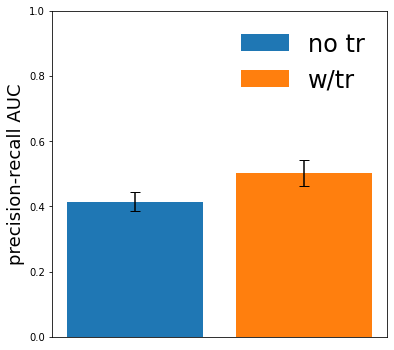

In [190]:
fig, ax = plt.subplots()
fig.set_size_inches(6,6)
x = [np.mean(scores), np.mean(scores_tr)]
ax.bar([0],[x[0]],width=0.4,label='no tr',yerr=np.std(scores)/np.sqrt(len(scores)),capsize=5)
ax.bar([0.5],[x[1]],width=0.4,label='w/tr',yerr=np.std(scores_tr)/np.sqrt(len(scores_tr)),capsize=5)
ax.set_ylim(0,1)
ax.legend(frameon=False,fontsize=24)
ax.set_ylabel('precision-recall AUC',fontsize=18)
ax.set_xticks([])

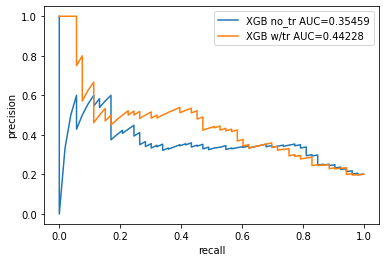

In [ ]:
fig = plt.figure()
ax = fig.subplots()

yreal = np.concatenate(y_real)
yproba = np.concatenate(y_proba)
p, r, _ = precision_recall_curve(yreal, yproba)
auc = np.trapz(p[::-1],r[::-1])
ax.plot(r,p,label='XGB no_tr AUC={:.5f}'.format(auc))


yreal = np.concatenate(y_real_tr)
yproba = np.concatenate(y_proba_tr)
p, r, _ = precision_recall_curve(yreal, yproba)
auc = np.trapz(p[::-1],r[::-1])
ax.plot(r,p,label='XGB w/tr AUC={:.5f}'.format(auc))

ax.set_xlabel('recall')
ax.set_ylabel('precision')
ax.legend()
plt.show()
#fig.savefig('AUC_test.png')

In [ ]:
model = model_tr
model

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.5255383009693526, gamma=0,
              learning_rate=0.061658177798448524, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=253, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=0.8779782890904051,
              use_label_encoder=False, verbosity=1)

In [ ]:
active_uM = 5.0
f_str = ','.join(columns_moonshot_tr)
q = f"""
CREATE OR REPLACE MODEL moonshot.xgbmodel
OPTIONS(MODEL_TYPE='BOOSTED_TREE_CLASSIFIER',
        DATA_SPLIT_METHOD = 'NO_SPLIT',
        BOOSTER_TYPE = '{model.booster}',
        MIN_TREE_CHILD_WEIGHT = {model.min_child_weight},
        MAX_TREE_DEPTH = {model.max_depth},
        MIN_SPLIT_LOSS={model.gamma},
        NUM_PARALLEL_TREE = 1,
        LEARN_RATE={model.learning_rate},
        MAX_ITERATIONS = {model.n_estimators},
        TREE_METHOD = 'AUTO',
        EARLY_STOP = FALSE,
        SUBSAMPLE = {model.subsample},
        COLSAMPLE_BYTREE = {model.colsample_bytree},
        INPUT_LABEL_COLS = ['active'])
AS SELECT (f_avg_IC50 < {active_uM}) AS active,
          {f_str}
FROM moonshot.mpro_features
INNER JOIN moonshot.activities
ON activities.CID = mpro_features.string_field_0
WHERE f_avg_IC50 IS NOT NULL
"""
from google.cloud import bigquery
client = bigquery.Client(project=project_id)
client.query(q).to_dataframe()

""


In [184]:
feat = pd.DataFrame(model.feature_importances_, index=columns_moonshot_tr, columns=['importance'])
with pd.option_context('display.max_rows', None):  # more options can be specified also
    print(feat.sort_values(by='importance', ascending=False))

            importance
SER_144_PB    0.079609
THR_25_AB     0.069595
SER_144_tr    0.065462
CYS_145_PB    0.058191
ASN_142_AB    0.056008
CYS_145_tr    0.049868
HSD_41_PB     0.039649
GLN_189_AB    0.037348
ASP_187_AB    0.037216
ARG_188_PB    0.037068
GLN_189_PB    0.034200
GLU_166_AB    0.033462
MET_165_AB    0.031400
ASN_142_tr    0.030791
PHE_140_PB    0.030230
HSE_164_PB    0.030139
HSD_41_AB     0.029566
MET_49_AB     0.028417
ASP_187_PB    0.027566
CYS_44_PB     0.026704
GLY_143_PB    0.025147
ASN_142_PB    0.024672
GLU_166_PB    0.024547
TYR_54_PB     0.023374
THR_190_PB    0.022377
GLU_166_tr    0.020410
MET_165_PB    0.018655
THR_25_PB     0.008331
ASN_119_AB    0.000000
ASP_187_tr    0.000000
LEU_167_AB    0.000000
LEU_167_tr    0.000000
PRO_168_PB    0.000000
PRO_168_AB    0.000000
PRO_168_tr    0.000000
HSE_172_PB    0.000000
HSE_172_AB    0.000000
HSE_172_tr    0.000000
PHE_185_PB    0.000000
PHE_185_AB    0.000000
PHE_185_tr    0.000000
LEU_27_AB     0.000000
LEU_27_PB  

In [185]:
%%bigquery --project $project_id df_xgboost
SELECT name, __residual_activity, predicted_active_probs[OFFSET(0)].prob AS xgb_score
FROM ML.PREDICT(MODEL `moonshot.xgbmodel`,
  (SELECT A.*, exp.__residual_activity FROM mpro_5r84.mpro_features AS A
   INNER JOIN mpro_exp.hit_expansion AS exp
   ON STARTS_WITH(A.name,exp.Inhibitor)))
ORDER BY xgb_score DESC

Executing query with job ID: 3fa32c89-724e-4e73-8993-20f54f1fc036
Query executing: 0.96s


ERROR:
 400 Invalid table-valued function ML.PREDICT
Column LEU_27_PB is not found in the input data to the PREDICT function. at [2:6]

(job ID: 3fa32c89-724e-4e73-8993-20f54f1fc036)

                             -----Query Job SQL Follows-----                              

    |    .    |    .    |    .    |    .    |    .    |    .    |    .    |    .    |
   1:SELECT name, __residual_activity, predicted_active_probs[OFFSET(0)].prob AS xgb_score
   2:FROM ML.PREDICT(MODEL `moonshot.xgbmodel`,
   3:  (SELECT A.*, exp.__residual_activity FROM mpro_5r84.mpro_features AS A
   4:   INNER JOIN mpro_exp.hit_expansion AS exp
   5:   ON STARTS_WITH(A.name,exp.Inhibitor)))
   6:ORDER BY xgb_score DESC
    |    .    |    .    |    .    |    .    |    .    |    .    |    .    |    .    |
